# Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast datasetsforecast

In [ ]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM

from hierarchicalforecast.utils import is_strictly_hierarchical
from hierarchicalforecast.utils import HierarchicalPlot, CodeTimer
from hierarchicalforecast.evaluation import scaled_crps, msse, energy_score

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
# ['Labour', 'Traffic', 'TourismSmall', 'TourismLarge', 'Wiki2']
dataset = 'TourismSmall' # 'TourismLarge'
verbose = True
intervals_method = 'bootstrap'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    horizon = dataset_info.horizon
    seasonality = dataset_info.seasonality
    Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    S_df = S_df.reset_index(names="unique_id")

TourismSmall
Code block 'Read and Parse data   ' took:	0.00554 seconds


In [ ]:
dataset_info.seasonality

4

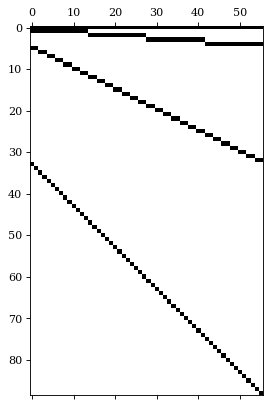

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_train_df

unique_id         ds      y
0              total 1998-03-31  84503
1              total 1998-06-30  65312
2              total 1998-09-30  72753
3              total 1998-12-31  70880
4              total 1999-03-31  86893
...              ...        ...    ...
3191  nt-oth-noncity 2003-12-31    132
3192  nt-oth-noncity 2004-03-31     12
3193  nt-oth-noncity 2004-06-30     40
3194  nt-oth-noncity 2004-09-30    186
3195  nt-oth-noncity 2004-12-31    144

[2492 rows x 3 columns]

### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file)
        Y_fitted_df = pd.read_csv(yfitted_file)

    else:
        fcst = StatsForecast(
            df=Y_train_df, 
            models=[AutoARIMA(season_length=seasonality)],
            fallback_model=[Naive()],
            freq='M', 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(h=horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file)
        Y_fitted_df.to_csv(yfitted_file)

In [ ]:
Y_hat_df

unique_id          ds    AutoARIMA  AutoARIMA-lo-98  \
0               bus  2005-01-31   9673.42500       7485.52900   
1               bus  2005-02-28  10393.90000       8206.00400   
2               bus  2005-03-31  12028.13500       9840.23800   
3               bus  2005-04-30  10995.68000       8807.78300   
4               bus  2005-05-31   9673.42500       7315.08840   
..              ...         ...          ...              ...   
707  wa-vfr-noncity  2005-04-30    904.12555        471.93066   
708  wa-vfr-noncity  2005-05-31    904.12555        466.27844   
709  wa-vfr-noncity  2005-06-30    904.12555        460.69827   
710  wa-vfr-noncity  2005-07-31    904.12555        455.18744   
711  wa-vfr-noncity  2005-08-31    904.12555        449.74344   

     AutoARIMA-lo-96  AutoARIMA-lo-94  AutoARIMA-lo-92  AutoARIMA-lo-90  \
0         7741.90400        7904.5660       8026.93000       8126.46400   
1         8462.38000        8625.0410       8747.40500       8846.93900   
2        10096.61400       10259.2760      10381.64100      10481.17400   
3         9064.15800        9226.8200       9349.18500       9448.71900   
4         7591.43550        7766.7690       7898.66550       8005.95360   
..               ...              ...              ...              ...   
707        522.57480         554.7069        578.87860        598.54040   
708        517.58490         550.1372        574.62506        594.54400   
709        512.65860         545.6258        570.42566        590.59850   
710        507.79352         541.1704        566.27850        586.70200   
711        502.98746         536.7691        562.18164        582.85284   

     AutoARIMA-lo-88  AutoARIMA-lo-86  ...  AutoARIMA-hi-80  AutoARIMA-hi-82  \
0         8211.18300       8285.46500  ...       10878.7050       10934.3860   
1         8931.65800       9005.94000  ...       11599.1810       11654.8610   
2        10565.89300      10640.17500  ...       13233.4150       13289.0960   
3         9533.43750       9607.72000  ...       12200.9600       12256.6400   
4         8097.27200       8177.34100  ...       10972.5990       11032.6160   
..               ...              ...  ...              ...              ...   
707        615.27570        629.94930  ...        1142.2155        1153.2145   
708        611.49817        626.36365  ...        1145.3292        1156.4720   
709        607.76874        622.82367  ...        1148.4033        1159.6881   
710        604.08570        619.32770  ...        1151.4391        1162.8641   
711        600.44727        615.87415  ...        1154.4381        1166.0017   

     AutoARIMA-hi-84  AutoARIMA-hi-86  AutoARIMA-hi-88  AutoARIMA-hi-90  \
0         10994.8740       11061.3850       11135.6670       11220.3860   
1         11715.3500       11781.8600       11856.1430       11940.8610   
2         13349.5840       13416.0950       13490.3770       13575.0960   
3         12317.1290       12383.6400       12457.9210       12542.6410   
4         11097.8170       11169.5090       11249.5780       11340.8960   
..               ...              ...              ...              ...   
707        1165.1633        1178.3018        1192.9753        1209.7107   
708        1168.5771        1181.8875        1196.7529        1213.7072   
709        1171.9475        1185.4274        1200.4823        1217.6526   
710        1175.2760        1188.9233        1204.1654        1221.5491   
711        1178.5641        1192.3770        1207.8038        1225.3982   

     AutoARIMA-hi-92  AutoARIMA-hi-94  AutoARIMA-hi-96  AutoARIMA-hi-98  
0         11319.9200       11442.2840       11604.9460       11861.3210  
1         12040.3955       12162.7600       12325.4210       12581.7970  
2         13674.6300       13796.9940       13959.6560       14216.0310  
3         12642.1740       12764.5380       12927.2000       13183.5750  
4         11448.1850       11580.0810       11755.4140       12031.7620  
..               ...  

In [ ]:
Y_fitted_df

unique_id          ds        y    AutoARIMA  AutoARIMA-lo-98  \
0                bus  1998-03-31   9815.0   9805.18500       7617.80960   
1                bus  1998-06-30  11823.0  11811.17700       9623.80200   
2                bus  1998-09-30  13565.0  13551.43500      11364.06000   
3                bus  1998-12-31  11478.0  11466.52200       9279.14600   
4                bus  1999-03-31  10027.0   9845.01200       7657.63600   
...              ...         ...      ...          ...              ...   
2487  wa-vfr-noncity  2003-12-31   1177.0    927.35120        512.57690   
2488  wa-vfr-noncity  2004-03-31    956.0    969.56555        554.79126   
2489  wa-vfr-noncity  2004-06-30    772.0    967.26890        552.49457   
2490  wa-vfr-noncity  2004-09-30    885.0    934.25183        519.47750   
2491  wa-vfr-noncity  2004-12-31    797.0    925.92346        511.14914   

      AutoARIMA-lo-96  AutoARIMA-lo-94  AutoARIMA-lo-92  AutoARIMA-lo-90  \
0          7874.12400       8036.74700       8159.08250       8258.59300   
1          9880.11600      10042.73900      10165.07400      10264.58400   
2         11620.37400      11782.99700      11905.33200      12004.84300   
3          9535.46100       9698.08400       9820.41900       9919.93000   
4          7913.95070       8076.57370       8198.90900       8298.41900   
...               ...              ...              ...              ...   
2487        561.17970        592.01660        615.21405        634.08340   
2488        603.39404        634.23096        657.42840        676.29770   
2489        601.09740        631.93430        655.13180        674.00104   
2490        568.08030        598.91724        622.11460        640.98395   
2491        559.75195        590.58887        613.78630        632.65560   

      AutoARIMA-lo-88  ...  AutoARIMA-hi-80  AutoARIMA-hi-82  AutoARIMA-hi-84  \
0          8343.29100  ...       11010.1790       11065.8460       11126.3190   
1         10349.28300  ...       13016.1710       13071.8370       13132.3120   
2         12089.54100  ...       14756.4290       14812.0960       14872.5690   
3         10004.62800  ...       12671.5160       12727.1830       12787.6560   
4          8383.11800  ...       11050.0050       11105.6720       11166.1460   
...               ...  ...              ...              ...              ...   
2487        650.14410  ...        1155.8444        1166.4000        1177.8673   
2488        692.35846  ...        1198.0587        1208.6144        1220.0817   
2489        690.06180  ...        1195.7621        1206.3177        1217.7850   
2490        657.04470  ...        1162.7450        1173.3007        1184.7680   
2491        648.71640  ...        1154.4166        1164.9723        1176.4396   

      AutoARIMA-hi-86  AutoARIMA-hi-88  AutoARIMA-hi-90  AutoARIMA-hi-92  \
0          11192.8140       11267.0790       11351.7770       11451.2880   
1          13198.8070       13273.0700       13357.7700       13457.2790   
2          14939.0640       15013.3290       15098.0270       15197.5380   
3          12854.1510       12928.4160       13013.1140       13112.6250   
4          11232.6420       11306.9050       11391.6045       11491.1140   
...               ...              ...              ...              ...   
2487        1190.4762        1204.5583        1220.6190        1239.4884   
2488        1232.6906        1246.7727        1262.8334        1281.7028   
2489        1230.3939        1244.4761        1260.5367        1279.4061   
2490        1197.3768        1211.4589        1227.5197        1246.3889   
2491        1189.0485        1203.1306        1219.1913        1238.0607   

      AutoARIMA-hi-94  AutoARIMA-hi-96  AutoARIMA-hi-98  
0          11573.6230       11736.2460       11992.5610  
1          13579.6150       13742.2380       13998.5530  
2          15319.8730       15482.4960       15738.8110  
3          13234.9600       13397.5830       13653.8970  
4          11613.4490

## 3. Reconcile Predictions

In [ ]:
with CodeTimer('Reconcile Predictions ', verbose):
    if is_strictly_hierarchical(S=S_df.drop(columns="unique_id").values.astype(np.float32), 
        tags={key: S_df.index.get_indexer(val) for key, val in tags.items()}):
        reconcilers = [
            BottomUp(),
            TopDown(method='average_proportions'),
            TopDown(method='proportion_averages'),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
            ERM(method='closed')
        ]
    else:
        reconcilers = [
            BottomUp(),
            MinTrace(method='ols'),
            MinTrace(method='wls_var'),
            MinTrace(method='mint_shrink'),
            #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
            ERM(method='closed')
        ]
    
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_df,
                                        Y_df=Y_fitted_df,
                                        S_df=S_df, tags=tags,
                                        level=LEVEL,
                                        intervals_method=intervals_method,
                                        num_samples=10, num_seeds=10)

    # Matching Y_test/Y_rec/S index ordering
    Y_test_df = Y_test_df.reset_index()
    Y_test_df.unique_id = Y_test_df.unique_id.astype('category')
    Y_test_df.unique_id = Y_test_df.unique_id.cat.set_categories(S_df.index)
    Y_test_df = Y_test_df.sort_values(by=['unique_id', 'ds'])

    Y_rec_df = Y_rec_df.reset_index()
    Y_rec_df.unique_id = Y_rec_df.unique_id.astype('category')
    Y_rec_df.unique_id = Y_rec_df.unique_id.cat.set_categories(S_df.index)
    Y_rec_df = Y_rec_df.sort_values(by=['seed', 'unique_id', 'ds'])

    # Parsing model level columns
    flat_cols = list(hrec.level_names.keys())
    for model in hrec.level_names:
        flat_cols += hrec.level_names[model]
    for model in hrec.sample_names:
        flat_cols += hrec.sample_names[model]
    y_rec  = Y_rec_df[flat_cols]
    model_columns = y_rec.columns

    n_series = len(S_df)
    n_seeds = len(Y_rec_df.seed.unique())
    y_rec  = y_rec.values.reshape(n_seeds, n_series, horizon, len(model_columns))
    y_test = Y_test_df['y'].values.reshape(n_series, horizon)
    y_train = Y_train_df['y'].values.reshape(n_series, -1)

Code block 'Reconcile Predictions ' took:	3.45972 seconds


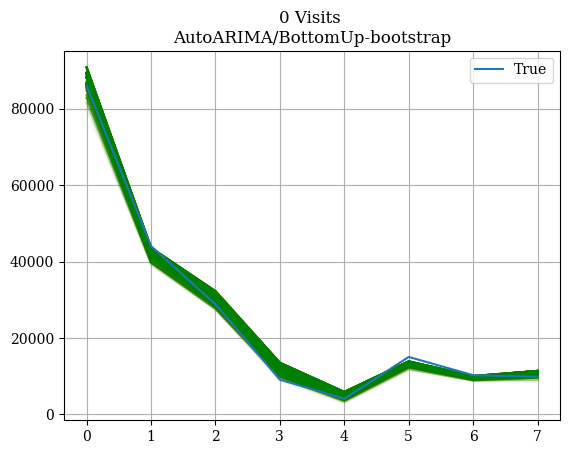

In [ ]:
# Qualitative evaluation, of parsed quantiles
row_idx = 0
seed_idx = 0
col_idxs = model_columns.get_indexer(hrec.level_names['AutoARIMA/BottomUp'])
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx, row_idx,:,col], color='orange', alpha=i/100)
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx+1, row_idx,:,col], color='green', alpha=i/100)
plt.plot(y_test[row_idx,:], label='True')
plt.title(f'{S_df.index[row_idx]} Visits \n' + \
          f'AutoARIMA/BottomUp-{intervals_method}')

plt.legend()
plt.grid()
plt.show()
plt.close()

In [ ]:
hrec.level_names.keys()

dict_keys(['AutoARIMA/BottomUp', 'AutoARIMA/MinTrace_method-ols', 'AutoARIMA/MinTrace_method-wls_var', 'AutoARIMA/MinTrace_method-mint_shrink', 'AutoARIMA/ERM_method-closed_lambda_reg-0.01'])

In [ ]:
#Y_rec_df
td_levels = hrec.level_names['AutoARIMA/MinTrace_method-wls_var']
Y_rec_df[td_levels]

AutoARIMA/MinTrace_method-wls_var-lo-98  \
0                                80627.769380   
8                                39213.592750   
16                               27773.866809   
24                                9044.814054   
32                                2960.361446   
...                                       ...   
7087                               327.336534   
7095                               -27.588684   
7103                               -47.235475   
7111                               -18.767069   
7119                               -44.632458   

      AutoARIMA/MinTrace_method-wls_var-lo-96  \
0                                80627.769380   
8                                39213.592750   
16                               27773.866809   
24                                9044.814054   
32                                2960.361446   
...                                       ...   
7087                               327.336534   
7095                               -27.588684   
7103                               -47.235475   
7111                               -18.767069   
7119                               -44.632458   

      AutoARIMA/MinTrace_method-wls_var-lo-94  \
0                                80627.769380   
8                                39360.103272   
16                               27773.866809   
24                                9044.814054   
32                                2960.361446   
...                                       ...   
7087                               327.336534   
7095                               -27.588684   
7103                               -47.235475   
7111                               -18.767069   
7119                               -44.632458   

      AutoARIMA/MinTrace_method-wls_var-lo-92  \
0                                81784.608207   
8                                39364.634526   
16                               27773.866809   
24                                9399.296479   
32                                2960.361446   
...                                       ...   
7087                               327.336534   
7095                               -27.588684   
7103                               -47.235475   
7111                                 2.709114   
7119                               -44.632458   

      AutoARIMA/MinTrace_method-wls_var-lo-90  \
0                                81784.608207   
8                                39364.634526   
16                               27773.866809   
24                                9399.296479   
32                                3099.179401   
...                                       ...   
7087                               429.957002   
7095                               -24.655686   
7103                               -47.235475   
7111                                 3.603955   
7119                                 6.163725   

      AutoARIMA/MinTrace_method-wls_var-lo-88  \
0                                81784.608207   
8                                39364.634526   
16                               28109.726341   
24                                9399.296479   
32                                3106.485609   
...                                       ...   
7087                               429.957002   
7095                               -24.501317   
7103                               -47.235475   
7111                                 3.603955   
7119                                 8.837208   

      AutoARIMA/MinTrace_method-wls_var-lo-86  \
0                                83077.121240   
8                                39608.159443   
16                               28131.164184   
24                                9399.296479   
32                                3106.485609   
...                                       ...   
7087                               429.957002   
7095                               -24.501317   
7103                           

## 4. Evaluation

In [ ]:
with CodeTimer('Evaluate Models CRPS  ', verbose):
    crps_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}

    for model in hrec.level_names.keys():
        crps_results[model] = []
        for level in crps_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.level_names[model])
            _y = y_test[row_idxs,:]
            _y_rec_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idxs]

            level_model_crps = []
            for seed_idx in range(y_rec.shape[0]):
                _y_rec = _y_rec_seeds[seed_idx,:,:,:]
                level_model_crps.append(scaled_crps(y=_y, y_hat=_y_rec,
                                                    quantiles=QUANTILES))
            level_model_crps = f'{np.mean(level_model_crps):.4f}±{(1.96 * np.std(level_model_crps)):.4f}'
            crps_results[model].append(level_model_crps)

    crps_results = pd.DataFrame(crps_results)

crps_results

Code block 'Evaluate Models CRPS  ' took:	0.21466 seconds


Dataset                              Level AutoARIMA/BottomUp  \
0  TourismSmall                            Overall      0.0871±0.0014   
1  TourismSmall                            Country      0.3622±0.0201   
2  TourismSmall                    Country/Purpose      0.3622±0.0201   
3  TourismSmall              Country/Purpose/State      0.3622±0.0201   
4  TourismSmall  Country/Purpose/State/CityNonCity      0.3622±0.0201   

  AutoARIMA/MinTrace_method-ols AutoARIMA/MinTrace_method-wls_var  \
0                 0.0915±0.0010                     0.0896±0.0011   
1                 0.4523±0.0318                     0.3982±0.0261   
2                 0.4523±0.0318                     0.3982±0.0261   
3                 0.4523±0.0318                     0.3982±0.0261   
4                 0.4523±0.0318                     0.3982±0.0261   

  AutoARIMA/MinTrace_method-mint_shrink  \
0                         0.0914±0.0010   
1                         0.3873±0.0259   
2                         0.3873±0.0259   
3                         0.3873±0.0259   
4                         0.3873±0.0259   

  AutoARIMA/ERM_method-closed_lambda_reg-0.01  
0                               0.1166±0.0015  
1                               0.5373±0.0191  
2                               0.5373±0.0191  
3                               0.5373±0.0191  
4                               0.5373±0.0191

In [ ]:
with CodeTimer('Evaluate Models MSSE  ', verbose):
    msse_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.level_names.keys():
        msse_results[model] = []
        for level in msse_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idx = model_columns.get_loc(model)
            _y = y_test[row_idxs,:]
            _y_train = y_train[row_idxs,:]
            _y_hat_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idx]

            level_model_msse = []
            for seed_idx in range(y_rec.shape[0]):
                _y_hat = _y_hat_seeds[seed_idx,:,:]
                level_model_msse.append(msse(y=_y, y_hat=_y_hat, y_train=_y_train))
            #level_model_msse = f'{np.mean(level_model_msse):.4f}±{(1.96 * np.std(level_model_msse)):.4f}'
            level_model_msse = f'{np.mean(level_model_msse):.4f}'
            msse_results[model].append(level_model_msse)

    msse_results = pd.DataFrame(msse_results)

msse_results

Code block 'Evaluate Models MSSE  ' took:	0.12454 seconds


Dataset                              Level AutoARIMA/BottomUp  \
0  TourismSmall                            Overall             0.1414   
1  TourismSmall                            Country             0.7087   
2  TourismSmall                    Country/Purpose             0.7087   
3  TourismSmall              Country/Purpose/State             0.7087   
4  TourismSmall  Country/Purpose/State/CityNonCity             0.7087   

  AutoARIMA/MinTrace_method-ols AutoARIMA/MinTrace_method-wls_var  \
0                        0.1810                            0.1654   
1                        1.0526                            1.0039   
2                        1.0526                            1.0039   
3                        1.0526                            1.0039   
4                        1.0526                            1.0039   

  AutoARIMA/MinTrace_method-mint_shrink  \
0                                0.1745   
1                                0.9099   
2                                0.9099   
3                                0.9099   
4                                0.9099   

  AutoARIMA/ERM_method-closed_lambda_reg-0.01  
0                                      0.2586  
1                                      0.7010  
2                                      0.7010  
3                                      0.7010  
4                                      0.7010

In [ ]:
with CodeTimer('Evaluate Models EScore', verbose):
    energy_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                        'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.sample_names.keys():
        energy_results[model] = []
        for level in energy_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.sample_names[model])
            _y = y_test[row_idxs,:]
            _y_sample1 = y_rec[0,row_idxs,:,:][:,:,col_idxs[:len(col_idxs)//2]]
            _y_sample2 = y_rec[0,row_idxs,:,:][:,:,col_idxs[len(col_idxs)//2:]]
            level_model_energy = energy_score(y=_y, 
                                              y_sample1=_y_sample1,
                                              y_sample2=_y_sample2,
                                              beta=2)
            energy_results[model].append(level_model_energy)
    energy_results = pd.DataFrame(energy_results)

energy_results

Code block 'Evaluate Models EScore' took:	0.03231 seconds


Dataset                              Level  AutoARIMA/BottomUp  \
0  TourismSmall                            Overall        6.338492e+07   
1  TourismSmall                            Country        9.627871e+03   
2  TourismSmall                    Country/Purpose        3.851149e+04   
3  TourismSmall              Country/Purpose/State        2.695804e+05   
4  TourismSmall  Country/Purpose/State/CityNonCity        5.391608e+05   

   AutoARIMA/MinTrace_method-ols  AutoARIMA/MinTrace_method-wls_var  \
0                   6.868080e+07                       6.826128e+07   
1                   1.947318e+04                       1.470577e+04   
2                   7.789273e+04                       5.882307e+04   
3                   5.452491e+05                       4.117615e+05   
4                   1.090498e+06                       8.235230e+05   

   AutoARIMA/MinTrace_method-mint_shrink  \
0                           7.073327e+07   
1                           1.430874e+04   
2                           5.723497e+04   
3                           4.006448e+05   
4                           8.012895e+05   

   AutoARIMA/ERM_method-closed_lambda_reg-0.01  
0                                 8.459768e+07  
1                                 1.645688e+04  
2                                 6.582752e+04  
3                                 4.607927e+05  
4                                 9.215853e+05

## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)